In [238]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
%matplotlib inline
%aimport ichol_V
%aimport ichol
%aimport simulation
%aimport ichol_adadelta
%aimport ichol_normalize_m

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [239]:
import os.path
from datetime import datetime
import numpy as np
from scipy import linalg
from pylab import *
from sklearn.decomposition.factor_analysis import FactorAnalysis

import ichol, ichol_V, ichol_adadelta, ichol_normalize_m
import simulation

# No spike regression

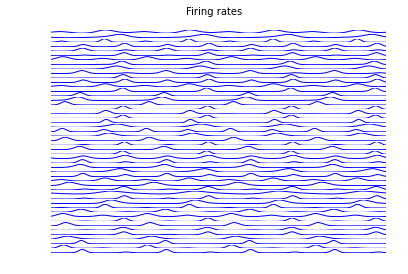

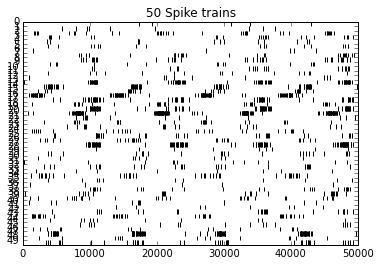

In [4]:
np.random.seed(0)

T = 50000
p = 0
L = 2
N = 50

high = np.log(25 / T)
low = np.log(5 / T)

# simulate latent processes
# x, ticks = simulation.latents(L, T, std, w)
x = np.empty((T, L), dtype=float)
# x[:T // 2, 0] = high
# x[T // 2:, 0] = low
# x[:, 1] = 2 * np.sin(np.linspace(0, 2 * np.pi * 5, T))
x[:, 0] = 2 * np.sin(0.0005 * np.arange(T) + np.pi)
x[:, 1] = 2 * np.sin(0.001 * np.arange(T))

for l in range(L):
    x[:, l] -= np.mean(x[:, l])

# simulate spike trains
a = 2 * np.random.rand(L, N) - 1
for l in range(L):
    a[l, :] /= linalg.norm(a[l, :]) / np.sqrt(N)

b = np.empty((1 + p*N, N))
b[0, :] = low

y, _, rate = simulation.spikes(x, a, b, intercept=True)
figure()
_, ax = subplots(N, sharex=True)
for n in range(N):
    ax[n].plot(rate[:, n])
    ax[n].axis('off')
suptitle('Firing rates')

figure()
ylim(0, N)
for n in range(N):
    vlines(np.arange(T)[y[:, n] > 0], n, n + 1, color='black')
title('{} Spike trains'.format(N))
yticks(range(N))
gca().invert_yaxis()

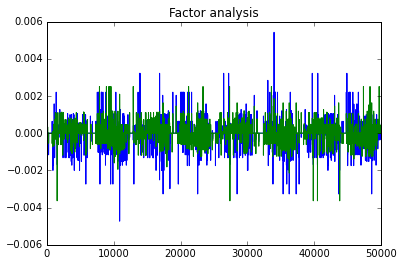

In [5]:
fa = FactorAnalysis(n_components=L)
m0 = fa.fit_transform(y)
a0 = fa.components_
# a0 = np.random.randn(L, N)
m0 *= np.linalg.norm(a0) / np.sqrt(N)
a0 /= np.linalg.norm(a0) / np.sqrt(N)

mu = np.zeros_like(x)

figure()
plot(m0)
title('Factor analysis')


Iteration[1]
lower bound = -1085232.75248
increment = 1543736.4060427595
time = 10.94s
change in alpha = 0.8076273012
change in beta = 0.9999000100
change in posterior mean = 0.0039211621
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[2]
lower bound = -396133.28451
increment = 689099.4679695286
time = 11.05s
change in alpha = 0.0048030128
change in beta = 0.9997282340
change in posterior mean = 0.0070385922
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[3]
lower bound = -180528.65801
increment = 215604.6265006130
time = 10.91s
change in alpha = 0.0054364241
change in beta = 0.9992614986
change in posterior mean = 0.0038792021
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[4]
lower bound = -103303.69266
increment = 77224.9653429822
time = 10.91s
change in alpha = 0.0062878762
change in beta = 0.9979942724
change in posterior mean = 0.0101463942
change in prior vari

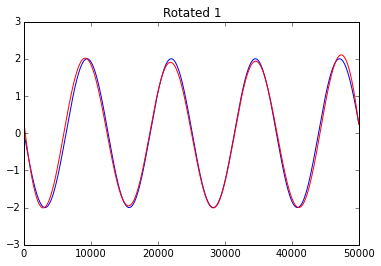

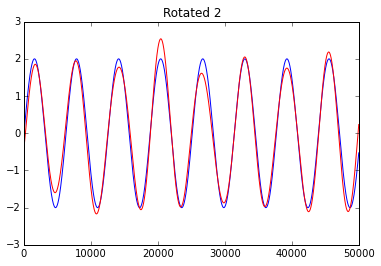

In [10]:
var = np.empty(L, dtype=float)
var[0] = 5
var[1] = 5
w = np.empty(L, dtype=float)
w[0] = 1e-8
w[1] = 1e-7
m1 = None
lbound, m1, a1, b1, var1, w1, a0, b0, elapsed, converged = ichol_adadelta.train(y, 0, var, w, b0=None, m0=m0, anorm=np.sqrt(N), hyper=False, kchol=100, niter=50, tol=1e-5, verbose=True)
c = linalg.lstsq(m1, x)[0]
rotated = np.dot(m1, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(rotated[:, l], label='transformed posterior', color='red')
    title('Rotated {}'.format(l + 1))

In [234]:
v = np.arange(5)

In [235]:
v

array([0, 1, 2, 3, 4])

In [237]:
np.linalg.norm(v, ord=inf)

4


Iteration[1]
lower bound = -1076997.60984
increment = 1579150.9005516027
time = 8.77s
change in alpha = 0.0031622771
change in beta = 0.9999000106
change in posterior mean = 0.0000000000
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[2]
lower bound = -497065.39948
increment = 579932.2103549768
time = 9.39s
change in alpha = 0.0044624846
change in beta = 0.9997282305
change in posterior mean = 0.0000000000
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[3]
lower bound = -218539.24873
increment = 278526.1507519509
time = 12.55s
change in alpha = 0.0049404665
change in beta = 0.9992778394
change in posterior mean = 0.9999993060
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[4]
lower bound = -106047.72836
increment = 112491.5203689739
time = 13.10s
change in alpha = 0.0074619660
change in beta = 0.9981184101
change in posterior mean = 0.9999973917
change in prior varia

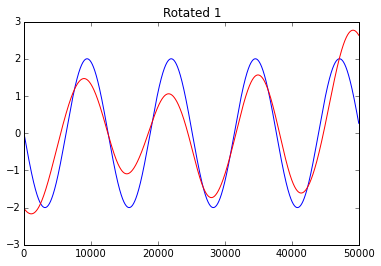

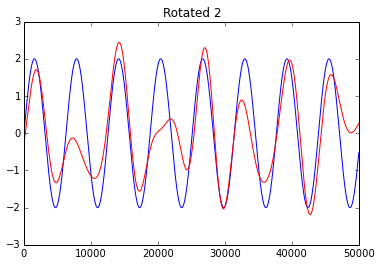

In [248]:
var = np.empty(L, dtype=float)
var[0] = 5
var[1] = 5
w = np.empty(L, dtype=float)
w[0] = 1e-8
w[1] = 1e-7
m1 = None
lbound, m1, a1, b1, var1, w1, a0, b0, elapsed, converged = ichol_normalize_m.train(y, 0, var, w, b0=None, m0=m0, anorm=np.sqrt(N), hyper=False, kchol=100, niter=50, tol=1e-5, verbose=True)
c = linalg.lstsq(m1, x)[0]
rotated = np.dot(m1, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(rotated[:, l], label='transformed posterior', color='red')
    title('Rotated {}'.format(l + 1))